In [1]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import cross_validate

In [ ]:
df1 = pd.read_csv("E:\MDA 2023\Full noise data\Jan\csv_results_42_255443_mp-06-parkstraat-2-la-filosovia.csv",delimiter=';')
df1 = df1[['result_timestamp','laeq']]
df2 = pd.read_csv("E:\MDA 2023\Full noise data\Feb\csv_results_42_255443_mp-06-parkstraat-2-la-filosovia.csv",delimiter=';')
df2 = df2[['result_timestamp','laeq']]
df3 = pd.read_csv("E:\MDA 2023\Full noise data\March\csv_results_44_255443_mp-06-parkstraat-2-la-filosovia.csv",delimiter=';')
df3 = df3[['result_timestamp','laeq']]
df4 = pd.read_csv("E:\MDA 2023\Full noise data\April\csv_results_45_255443_mp-06-parkstraat-2-la-filosovia.csv",delimiter=';')
df4 = df4[['result_timestamp','laeq']]
df5 = pd.read_csv("E:\MDA 2023\Full noise data\May\csv_results_46_255443_mp-06-parkstraat-2-la-filosovia.csv",delimiter=';')
df5 = df5[['result_timestamp','laeq']]
df6 = pd.read_csv("E:\MDA 2023\Full noise data\June\csv_results_47_255443_mp-06-parkstraat-2-la-filosovia.csv",delimiter=';')
df6 = df6[['result_timestamp','laeq']]
df7 = pd.read_csv("E:\MDA 2023\Full noise data\Jul\csv_results_48_255443_mp-06-parkstraat-2-la-filosovia.csv",delimiter=';')
df7 = df7[['result_timestamp','laeq']]
df8 = pd.read_csv("E:\MDA 2023\Full noise data\Aug\csv_results_49_255443_mp-06-parkstraat-2-la-filosovia.csv",delimiter=';')
df8 = df8[['result_timestamp','laeq']]
df9 = pd.read_csv("E:\MDA 2023\Full noise data\Sep\csv_results_50_255443_mp-06-parkstraat-2-la-filosovia.csv",delimiter=';')
df9 = df9[['result_timestamp','laeq']]
df10 = pd.read_csv("E:\MDA 2023\Full noise data\Oct\csv_results_51_255443_mp-06-parkstraat-2-la-filosovia.csv",delimiter=';')
df10 = df10[['result_timestamp','laeq']]
df11 = pd.read_csv("E:\MDA 2023\Full noise data\\Nov\csv_results_52_255443_mp-06-parkstraat-2-la-filosovia.csv",delimiter=';')
df11 = df11[['result_timestamp','laeq']]
df12 = pd.read_csv("E:\MDA 2023\Full noise data\Dec\csv_results_53_255443_mp-06-parkstraat-2-la-filosovia.csv",delimiter=';')
df12 = df12[['result_timestamp','laeq']]
dfn = pd.concat([df1,df2,df3,df4,df5,df6,df7,df8,df9,df10,df11,df12], axis=0)

In [ ]:
# Convert noise datetime column to a Pandas datetime object
dfn['result_timestamp'] = pd.to_datetime(dfn['result_timestamp'], format="%d/%m/%Y %H:%M:%S.%f")
df_backup = dfn

In [ ]:
#dfn = df_backup

In [ ]:
# set timestamp column as the index
dfn.set_index('result_timestamp', inplace=True)

In [ ]:
# resample to one minute frequency and aggregate using the mean
dfn = dfn.resample('10T').mean()

In [ ]:
# Drop the datetime column from the index and reset the index to default
dfn = dfn.reset_index()
dfn

,result_timestamp,laeq
0,2022-01-01 00:00:00,54.790667
1,2022-01-01 00:10:00,48.605833
2,2022-01-01 00:20:00,54.277833
3,2022-01-01 00:30:00,50.025333
4,2022-01-01 00:40:00,48.907333
...,...,...
52555,2022-12-31 23:10:00,52.203333
52556,2022-12-31 23:20:00,54.622833
52557,2022-12-31 23:30:00,56.135667
52558,2022-12-31 23:40:00,59.380333


In [ ]:
# Extract minute-in-the-hour feature (makes model slightly less accurate)
#dfn['minute'] = dfn['result_timestamp'].dt.minute.astype('int64')

# Extract hour-in-the-day feature
dfn['hour'] = dfn['result_timestamp'].dt.hour.astype('int64')

# Extract day-in-the-week feature
dfn['weekday'] = dfn['result_timestamp'].dt.dayofweek.astype('int64')

# Extract day-in-the-month feature
dfn['day_of_month'] = dfn['result_timestamp'].dt.day.astype('int64')

# Extract month-in-the-year feature
dfn['month'] = dfn['result_timestamp'].dt.month.astype('int64')

In [ ]:
#create numeric columns to merge on
dfn['result_timestamp'] = dfn['result_timestamp'].astype('int64')
dfn

,result_timestamp,laeq,hour,weekday,day_of_month,month
0,1640995200000000000,54.790667,0,5,1,1
1,1640995800000000000,48.605833,0,5,1,1
2,1640996400000000000,54.277833,0,5,1,1
3,1640997000000000000,50.025333,0,5,1,1
4,1640997600000000000,48.907333,0,5,1,1
...,...,...,...,...,...,...
52555,1672528200000000000,52.203333,23,5,31,12
52556,1672528800000000000,54.622833,23,5,31,12
52557,1672529400000000000,56.135667,23,5,31,12
52558,1672530000000000000,59.380333,23,5,31,12


In [ ]:
#get weather data
dfw1 = pd.read_csv("E:\MDA 2023\dataverse_files\LC_2022Q1.csv")
dfw1 = dfw1[dfw1['ID'] == 'LC-105']
dfw2 = pd.read_csv("E:\MDA 2023\dataverse_files\LC_2022Q2.csv")
dfw2 = dfw2[dfw2['ID'] == 'LC-105']
dfw3 = pd.read_csv("E:\MDA 2023\dataverse_files\LC_2022Q3.csv")
dfw3 = dfw3[dfw3['ID'] == 'LC-105']
dfw4 = pd.read_csv("E:\MDA 2023\dataverse_files\LC_2022Q4.csv")
dfw4 = dfw4[dfw4['ID'] == 'LC-105']
dfw = pd.concat([dfw1,dfw2,dfw3,dfw4],axis=0)
dfw = dfw[['DATEUTC', 'LC_HUMIDITY', 'LC_DWPTEMP', 'LC_n', 'LC_RAD', 'LC_RAININ', 'LC_DAILYRAIN','LC_WINDDIR',
          'LC_WINDSPEED', 'LC_RAD60', 'LC_TEMP_QCL0','LC_TEMP_QCL1','LC_TEMP_QCL2','LC_TEMP_QCL3']]

dfw['result_timestamp'] = dfw['DATEUTC']
dfw = dfw.drop(['DATEUTC'], axis=1)
dfw['result_timestamp'] = pd.to_datetime(dfw['result_timestamp'],format="%Y-%m-%d %H:%M:%S")
dfw['result_timestamp'] = dfw['result_timestamp'].astype('int64')
dfw = dfw[dfw.isnull()['LC_HUMIDITY']==False]
dfw = dfw[dfw['result_timestamp'].duplicated()==False]
dfw.duplicated().sum()

0

In [2]:
#load kmi data
dfkmi = pd.read_csv("E:\MDA 2023\\aws_10min.csv")
dfkmi = dfkmi[dfkmi['the_geom']=='POINT (3.202 51.348)']
dfkmi['timestamp'] = dfkmi['timestamp'].replace('T', ' ', regex=True)
dfkmi['timestamp'] = pd.to_datetime(dfkmi['timestamp'],format='%Y-%m-%d %H:%M:%S')
# Extract and select year 2022, Jan, 1 code
dfkmi['year'] = dfkmi['timestamp'].dt.year.astype('int64')
dfkmi['month'] = dfkmi['timestamp'].dt.month.astype('int64')
dfkmi = dfkmi[dfkmi['month']==1]
dfkmi = dfkmi[dfkmi['year']==2022]
dfkmi = dfkmi[dfkmi['code']==6418]

In [13]:
dfkmi.sort_values(by=['timestamp'])

,FID,the_geom,code,air_pressure,air_temperature,relative_humidity,precipitation,wind_speed,wind_direction,qc_flags,year,month
timestamp,,,,,,,,,,,,
2022-01-01 00:00:00,aws_10min.fid--160ead3a_187e1c9f3dc_-7c63,POINT (3.202 51.348),6418,1021.77,10.59,92.84,0.0,4.06,191.3,"{""validated"": {""air_pressure"":true,""air_temper...",2022,1
2022-01-01 00:10:00,aws_10min.fid--160ead3a_187e1c9f3dc_-7922,POINT (3.202 51.348),6418,1021.82,10.88,93.00,0.0,4.14,193.4,"{""validated"": {""air_pressure"":true,""air_temper...",2022,1
2022-01-01 00:20:00,aws_10min.fid--160ead3a_187e1c9f880_-4620,POINT (3.202 51.348),6418,1021.87,10.82,93.06,0.0,4.67,188.2,"{""validated"": {""air_pressure"":true,""air_temper...",2022,1
2022-01-01 00:30:00,aws_10min.fid--160ead3a_187e1c9f3dc_-7e7b,POINT (3.202 51.348),6418,1021.76,11.03,93.31,0.0,5.00,189.8,"{""validated"": {""air_pressure"":true,""air_temper...",2022,1
2022-01-01 00:40:00,aws_10min.fid--160ead3a_187e1c9f880_-461e,POINT (3.202 51.348),6418,1021.75,11.34,93.26,0.0,5.54,191.7,"{""validated"": {""air_pressure"":true,""air_temper...",2022,1
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-31 23:10:00,aws_10min.fid--160ead3a_187e1c9f3dc_140e,POINT (3.202 51.348),6418,1022.33,6.00,62.65,0.0,7.34,308.9,"{""validated"": {""air_pressure"":true,""air_temper...",2022,1
2022-01-31 23:20:00,aws_10min.fid--160ead3a_187e1c9f3dc_45b,POINT (3.202 51.348),6418,1022.42,6.07,62.02,0.0,8.01,308.1,"{""validated"": {""air_pressure"":true,""air_temper...",2022,1
2022-01-31 23:30:00,aws_10min.fid--160ead3a_187e1c9f880_-514c,POINT (3.202 51.348),6418,1022.60,6.07,62.03,0.0,7.54,307.8,"{""validated"": {""air_pressure"":true,""air_temper...",2022,1


In [10]:
dfkmi.reset_index()

,timestamp,FID,the_geom,code,air_pressure,air_temperature,relative_humidity,precipitation,wind_speed,wind_direction,qc_flags,year,month
0,2022-01-05 00:00:00,aws_10min.fid--160ead3a_187e1c9ef2c_7e92,POINT (3.202 51.348),6418,1002.20,4.65,65.97,0.00,8.33,297.2,"{""validated"": {""air_pressure"":true,""air_temper...",2022,1
1,2022-01-05 02:50:00,aws_10min.fid--160ead3a_187e1c9ef2c_7e93,POINT (3.202 51.348),6418,1002.82,4.94,68.74,0.00,9.80,286.9,"{""validated"": {""air_pressure"":true,""air_temper...",2022,1
2,2022-01-04 11:00:00,aws_10min.fid--160ead3a_187e1c9ef2c_7f2d,POINT (3.202 51.348),6418,996.32,8.61,92.16,0.18,3.75,305.5,"{""validated"": {""air_pressure"":true,""air_temper...",2022,1
3,2022-01-04 13:20:00,aws_10min.fid--160ead3a_187e1c9ef2c_7f2e,POINT (3.202 51.348),6418,996.37,7.77,91.94,0.00,6.54,0.8,"{""validated"": {""air_pressure"":true,""air_temper...",2022,1
4,2022-01-02 13:50:00,aws_10min.fid--160ead3a_187e1c9f3dc_-7faa,POINT (3.202 51.348),6418,1010.90,11.48,83.64,0.00,9.03,234.8,"{""validated"": {""air_pressure"":false,""air_tempe...",2022,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4459,2022-01-05 13:20:00,aws_10min.fid--160ead3a_187e1c9f880_-4323,POINT (3.202 51.348),6418,1009.69,6.40,72.22,0.00,10.17,308.5,"{""validated"": {""air_pressure"":true,""air_temper...",2022,1
4460,2022-01-05 13:30:00,aws_10min.fid--160ead3a_187e1c9f880_-4322,POINT (3.202 51.348),6418,1009.78,6.36,72.21,0.00,9.51,303.5,"{""validated"": {""air_pressure"":true,""air_temper...",2022,1
4461,2022-01-05 13:50:00,aws_10min.fid--160ead3a_187e1c9f880_-4321,POINT (3.202 51.348),6418,1010.12,6.48,72.19,0.00,8.82,303.4,"{""validated"": {""air_pressure"":true,""air_temper...",2022,1
4462,2022-01-05 14:00:00,aws_10min.fid--160ead3a_187e1c9f880_-431f,POINT (3.202 51.348),6418,1010.12,6.48,72.12,0.00,7.87,298.3,"{""validated"": {""air_pressure"":true,""air_temper...",2022,1


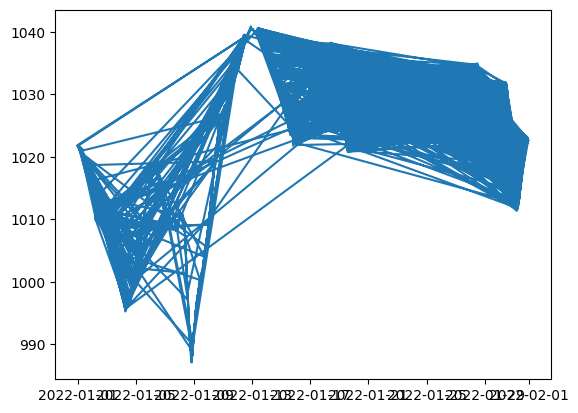

In [14]:
plt.plot(dfkmi['air_pressure'])

In [ ]:
#merge noise and weather data
df = pd.merge(dfn,dfw,on='result_timestamp', validate="1:1")

In [ ]:
df['result_timestamp'] = pd.to_datetime(df['result_timestamp'])
df

,result_timestamp,laeq,hour,weekday,day_of_month,month,LC_HUMIDITY,LC_DWPTEMP,LC_n,LC_RAD,LC_RAININ,LC_DAILYRAIN,LC_WINDDIR,LC_WINDSPEED,LC_RAD60,LC_TEMP_QCL0,LC_TEMP_QCL1,LC_TEMP_QCL2,LC_TEMP_QCL3
0,2022-01-01 00:10:00,48.605833,0,5,1,1,91.0,11.88,38.0,0.0,0.0,0.0,-48.0,0.04,0.0,13.28,13.28,13.223,13.23639
1,2022-01-01 00:20:00,54.277833,0,5,1,1,90.0,11.72,37.0,0.0,0.0,0.0,45.0,0.02,0.0,13.28,13.28,13.223,13.16699
2,2022-01-01 00:30:00,50.025333,0,5,1,1,90.0,11.72,38.0,0.0,0.0,0.0,-52.0,0.04,0.0,13.28,13.28,13.223,13.19886
3,2022-01-01 00:40:00,48.907333,0,5,1,1,90.0,11.72,37.0,0.0,0.0,0.0,34.0,0.02,0.0,13.28,13.28,13.223,13.16699
4,2022-01-01 00:50:00,47.905000,0,5,1,1,90.0,11.72,38.0,0.0,0.0,0.0,0.0,0.00,0.0,13.28,13.28,13.223,13.09212
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52548,2022-12-31 23:10:00,52.203333,23,5,31,12,52.0,6.79,38.0,0.0,0.0,0.0,-9.0,0.40,0.0,16.61,16.61,16.553,16.52797
52549,2022-12-31 23:20:00,54.622833,23,5,31,12,52.0,6.74,38.0,0.0,0.0,0.0,5.0,0.29,0.0,16.61,16.61,16.553,16.57995
52550,2022-12-31 23:30:00,56.135667,23,5,31,12,52.0,6.62,37.0,0.0,0.0,0.0,-17.0,0.15,0.0,16.51,16.51,16.453,16.44846
52551,2022-12-31 23:40:00,59.380333,23,5,31,12,52.0,6.60,38.0,0.0,0.0,0.0,-31.0,0.29,0.0,16.49,16.49,16.433,16.46641


In [ ]:
# check for missings
df.isnull().sum()

result_timestamp     0
laeq                84
hour                 0
weekday              0
day_of_month         0
month                0
LC_HUMIDITY          0
LC_DWPTEMP           0
LC_n                 0
LC_RAD               0
LC_RAININ            0
LC_DAILYRAIN         0
LC_WINDDIR           0
LC_WINDSPEED         0
LC_RAD60             0
LC_TEMP_QCL0         0
LC_TEMP_QCL1        54
LC_TEMP_QCL2        54
LC_TEMP_QCL3        54
dtype: int64

In [ ]:
# only keep rows without missings
df=df[df.isnull()['LC_TEMP_QCL2']==False]
df=df[df.isnull()['laeq']==False]

In [ ]:
#doublecheck whether missings are gone
df.isnull().sum()

result_timestamp    0
laeq                0
hour                0
weekday             0
day_of_month        0
month               0
LC_HUMIDITY         0
LC_DWPTEMP          0
LC_n                0
LC_RAD              0
LC_RAININ           0
LC_DAILYRAIN        0
LC_WINDDIR          0
LC_WINDSPEED        0
LC_RAD60            0
LC_TEMP_QCL0        0
LC_TEMP_QCL1        0
LC_TEMP_QCL2        0
LC_TEMP_QCL3        0
dtype: int64

In [ ]:
# Drop the datetime column
df_nd = df.drop('result_timestamp', axis=1)

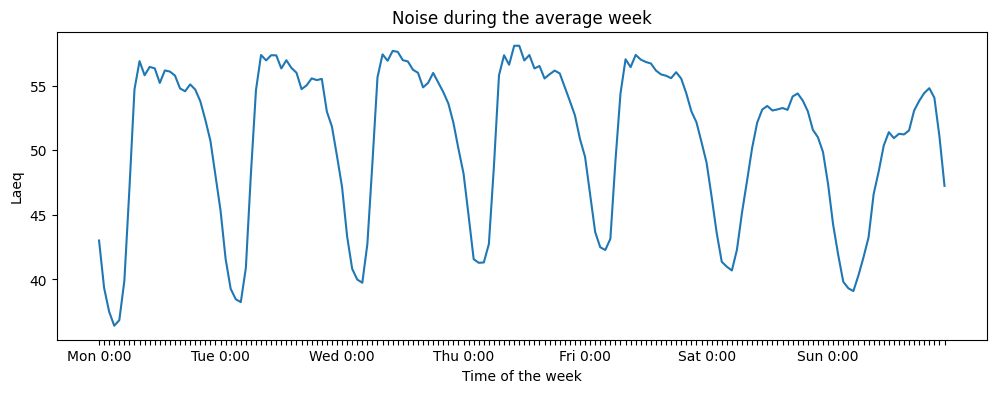

In [ ]:
fig, ax = plt.subplots(figsize=(12, 4))
average_week_noise = df_nd.groupby(["weekday", "hour"])["laeq"].mean()
average_week_noise.plot(ax=ax)
_ = ax.set(
    title="Noise during the average week",
    xticks=range(168),
    xticklabels=["Mon 0:00", "", "", "", "", "", "", "", "", "", "", "",
                  "", "", "", "", "", "", "", "", "", "", "", "",
                 "Tue 0:00", "", "", "", "", "", "", "", "", "", "", "",
                  "", "", "", "", "", "", "", "", "", "", "", "",
                 "Wed 0:00", "", "", "", "", "", "", "", "", "", "", "",
                  "", "", "", "", "", "", "", "", "", "", "", "",
                 "Thu 0:00", "", "", "", "", "", "", "", "", "", "", "",
                  "", "", "", "", "", "", "", "", "", "", "", "",
                 "Fri 0:00", "", "", "", "", "", "", "", "", "", "", "",
                  "", "", "", "", "", "", "", "", "", "", "", "",
                 "Sat 0:00", "", "", "", "", "", "", "", "", "", "", "",
                  "", "", "", "", "", "", "", "", "", "", "", "",
                 "Sun 0:00", "", "", "", "", "", "", "", "", "", "", "",
                  "", "", "", "", "", "", "", "", "", "", "", "",
                ],
    xlabel="Time of the week",
    ylabel="Laeq",
)

fig.savefig("Noise_average_week_feb2.png")


In [ ]:
#convert noise to relative noise (or relative crowdedness) as target (y), create dataframe with predictors only (X)
y = df_nd["laeq"] / df_nd["laeq"].max()
X = df_nd.drop("laeq", axis="columns")

In [ ]:
#create time-sensitive split for cross-validation
ts_cv = TimeSeriesSplit(
    n_splits=5,
    gap=48,
    max_train_size=10000,
    test_size=1000,
)

In [ ]:
#inspect splits
all_splits = list(ts_cv.split(X, y))
train_0, test_0 = all_splits[0]
X.iloc[test_0]
X.iloc[train_0]

,hour,weekday,day_of_month,month,LC_HUMIDITY,LC_DWPTEMP,LC_n,LC_RAD,LC_RAININ,LC_DAILYRAIN,LC_WINDDIR,LC_WINDSPEED,LC_RAD60,LC_TEMP_QCL0,LC_TEMP_QCL1,LC_TEMP_QCL2,LC_TEMP_QCL3
37474,6,6,18,9,90.0,8.66,31.0,11.0,0.0,0.002,-72.0,0.04,1.0,10.22,10.22,10.163,10.366350
37475,6,6,18,9,89.0,8.60,32.0,10.0,0.0,0.002,-70.0,0.04,1.0,10.26,10.26,10.203,10.370537
37476,6,6,18,9,89.0,8.61,32.0,16.0,0.0,0.002,-16.0,0.00,3.0,10.28,10.28,10.223,10.325881
37477,6,6,18,9,89.0,8.61,31.0,29.0,0.0,0.002,155.0,0.00,7.0,10.28,10.28,10.223,10.369574
37478,7,6,18,9,89.0,8.61,32.0,44.0,0.0,0.002,-66.0,0.01,10.0,10.34,10.34,10.283,10.436008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47493,20,5,26,11,89.0,5.78,37.0,0.0,0.0,0.000,49.0,0.05,0.0,7.50,7.50,7.443,7.478943
47494,20,5,26,11,89.0,5.78,38.0,0.0,0.0,0.000,42.0,0.03,0.0,7.50,7.50,7.443,7.466510
47495,21,5,26,11,89.0,5.78,37.0,0.0,0.0,0.000,-98.0,0.00,0.0,7.50,7.50,7.443,7.584603
47496,21,5,26,11,89.0,5.78,38.0,0.0,0.0,0.000,69.0,0.03,0.0,7.50,7.50,7.443,7.521966


In [ ]:
train_4, test_4 = all_splits[4]
X.iloc[test_4]
X.iloc[train_4]

,hour,weekday,day_of_month,month,LC_HUMIDITY,LC_DWPTEMP,LC_n,LC_RAD,LC_RAININ,LC_DAILYRAIN,LC_WINDDIR,LC_WINDSPEED,LC_RAD60,LC_TEMP_QCL0,LC_TEMP_QCL1,LC_TEMP_QCL2,LC_TEMP_QCL3
41483,3,6,16,10,90.0,11.75,37.0,0.0,0.0,0.000,173.0,0.00,0.0,13.39,13.39,13.333,13.30013
41484,3,6,16,10,90.0,11.76,38.0,0.0,0.0,0.000,79.0,0.01,0.0,13.35,13.35,13.293,13.27707
41485,3,6,16,10,90.0,11.72,37.0,0.0,0.0,0.000,-101.0,0.02,0.0,13.28,13.28,13.223,13.22240
41486,3,6,16,10,90.0,11.75,38.0,0.0,0.0,0.000,0.0,0.00,0.0,13.28,13.28,13.223,13.19272
41487,3,6,16,10,91.0,11.83,37.0,0.0,0.0,0.000,-43.0,0.00,0.0,13.28,13.28,13.223,13.20805
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51500,16,5,24,12,88.0,8.94,38.0,0.0,0.0,0.006,0.0,0.00,0.0,10.76,10.76,10.703,10.51092
51501,16,5,24,12,89.0,9.00,37.0,0.0,0.0,0.006,104.0,0.00,0.0,10.72,10.72,10.663,10.46496
51502,16,5,24,12,89.0,9.04,38.0,0.0,0.0,0.006,0.0,0.00,0.0,10.72,10.72,10.663,10.46642
51503,17,5,24,12,90.0,9.11,37.0,0.0,0.0,0.006,0.0,0.00,0.0,10.72,10.72,10.663,10.52329


In [ ]:
#run histogram gradient boosting model
def evaluate(model, X, y, cv):
    cv_results = cross_validate(
        model,
        X,
        y,
        cv=cv,
        scoring=["neg_mean_absolute_error", "neg_root_mean_squared_error"],
    )
    mae = -cv_results["test_neg_mean_absolute_error"]
    rmse = -cv_results["test_neg_root_mean_squared_error"]
    print(
        f"Mean Absolute Error:     {mae.mean():.3f} +/- {mae.std():.3f}\n"
        f"Root Mean Squared Error: {rmse.mean():.3f} +/- {rmse.std():.3f}"
    )

gbrt_pipeline = make_pipeline(HistGradientBoostingRegressor(max_leaf_nodes=5,learning_rate=0.21)).set_output(transform="pandas")

evaluate(gbrt_pipeline, X, y, cv=ts_cv)

Mean Absolute Error:     0.031 +/- 0.006
Root Mean Squared Error: 0.039 +/- 0.007


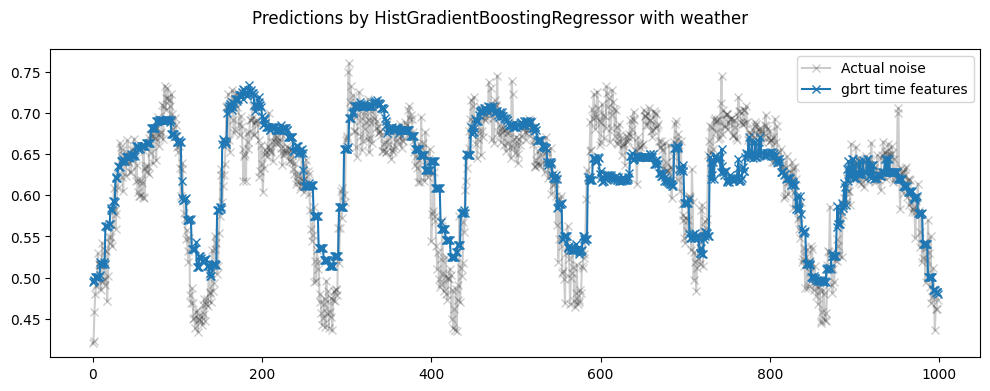

In [ ]:
#Qualitative analysis of the impact of features on linear model predictions
gbrt_pipeline.fit(X.iloc[train_0], y.iloc[train_0])
gbrt_predictions = gbrt_pipeline.predict(X.iloc[test_0])

last_hours = slice(-1000, None)
fig, ax = plt.subplots(figsize=(12, 4))
fig.suptitle("Predictions by HistGradientBoostingRegressor with weather")
ax.plot(
    y.iloc[test_0].values[last_hours],
    "x-",
    alpha=0.2,
    label="Actual noise",
    color="black",
)
ax.plot(gbrt_predictions[last_hours], "x-", label="gbrt time features")
_ = ax.legend()


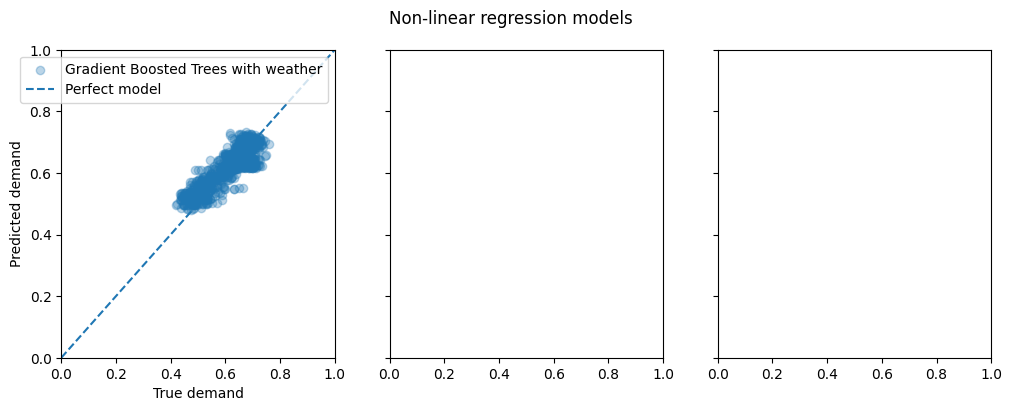

In [ ]:
fig, axes = plt.subplots(ncols=3, figsize=(12, 4), sharey=True)
fig.suptitle("Non-linear regression models")
predictions = [
    gbrt_predictions,
]
labels = [
    "Gradient Boosted Trees with weather",
]
for ax, pred, label in zip(axes, predictions, labels):
    ax.scatter(y.iloc[test_0].values, pred, alpha=0.3, label=label)
    ax.plot([0, 1], [0, 1], "--", label="Perfect model")
    ax.set(
        xlim=(0, 1),
        ylim=(0, 1),
        xlabel="True demand",
        ylabel="Predicted demand",
    )
    ax.legend()

plt.show()

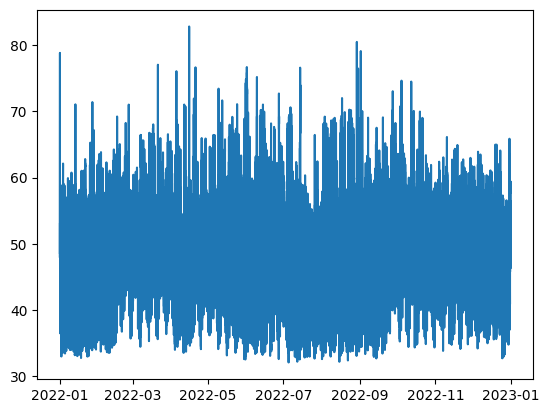

In [ ]:
plt.plot(df['result_timestamp'],df['laeq'])

In [ ]:
# grid search for hyperparameter tuning
from sklearn.model_selection import GridSearchCV
from sklearn.experimental import enable_hist_gradient_boosting

param_grid = {
    'learning_rate': (0.8, 0.9, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.20, 0.21, 0.22),
    'max_leaf_nodes': (4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15)}
model = HistGradientBoostingRegressor()
model_grid_search = GridSearchCV(model, param_grid=param_grid,
                                 n_jobs=2, cv=ts_cv)
model_grid_search.fit(X, y)


GridSearchCV(cv=TimeSeriesSplit(gap=48, max_train_size=10000, n_splits=5, test_size=1000),
             estimator=HistGradientBoostingRegressor(), n_jobs=2,
             param_grid={'learning_rate': (0.8, 0.9, 0.1, 0.11, 0.12, 0.13,
                                           0.14, 0.15, 0.16, 0.17, 0.18, 0.19,
                                           0.2, 0.21, 0.22),
                         'max_leaf_nodes': (4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                                            14, 15)})

In [ ]:
accuracy = model_grid_search.score(X, y)
print(
    f"The test accuracy score of the grid-searched pipeline is: "
    f"{accuracy:.2f}"
)

The test accuracy score of the grid-searched pipeline is: 0.79


In [ ]:
model_grid_search.predict(X.iloc[0:5])

array([0.56801298, 0.57093806, 0.56801298, 0.57093806, 0.56801298])

In [ ]:
print(f"The best set of parameters is: "
      f"{model_grid_search.best_params_}")

The best set of parameters is: {'learning_rate': 0.21, 'max_leaf_nodes': 5}


In [ ]:
cv_results = pd.DataFrame(model_grid_search.cv_results_).sort_values(
    "mean_test_score", ascending=False)
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_leaf_nodes,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
157,0.257649,0.002270,0.010273,0.000597,0.21,5,"{'learning_rate': 0.21, 'max_leaf_nodes': 5}",0.729750,0.847449,0.812192,0.712194,0.560421,0.732401,0.099594,1
170,0.297568,0.003646,0.011274,0.000402,0.22,6,"{'learning_rate': 0.22, 'max_leaf_nodes': 6}",0.738225,0.841590,0.831078,0.712455,0.512666,0.727203,0.118524,2
133,0.266435,0.003917,0.010372,0.000488,0.19,5,"{'learning_rate': 0.19, 'max_leaf_nodes': 5}",0.759073,0.844363,0.818220,0.722093,0.489920,0.726734,0.125980,3
169,0.257961,0.002354,0.010875,0.000493,0.22,5,"{'learning_rate': 0.22, 'max_leaf_nodes': 5}",0.741417,0.845019,0.817563,0.701937,0.517555,0.724698,0.115592,4
121,0.294791,0.008896,0.011274,0.000400,0.18,5,"{'learning_rate': 0.18, 'max_leaf_nodes': 5}",0.752288,0.842483,0.818635,0.718994,0.482354,0.722951,0.128224,5


In [ ]:
# get the parameter names
column_results = [f"param_{name}" for name in param_grid.keys()]
column_results += [
    "mean_test_score", "std_test_score", "rank_test_score"]
cv_results = cv_results[column_results]

In [ ]:
def shorten_param(param_name):
    if "__" in param_name:
        return param_name.rsplit("__", 1)[1]
    return param_name


cv_results = cv_results.rename(shorten_param, axis=1)
cv_results

,param_learning_rate,param_max_leaf_nodes,mean_test_score,std_test_score,rank_test_score
157,0.21,5,0.732401,0.099594,1
170,0.22,6,0.727203,0.118524,2
133,0.19,5,0.726734,0.125980,3
169,0.22,5,0.724698,0.115592,4
121,0.18,5,0.722951,0.128224,5
...,...,...,...,...,...
11,0.8,15,0.584457,0.175897,176
6,0.8,10,0.570409,0.195551,177
18,0.9,10,0.544080,0.223358,178
19,0.9,11,0.519401,0.162649,179


In [ ]:
pivoted_cv_results = cv_results.pivot_table(
    values="mean_test_score", index=["param_learning_rate"],
    columns=["param_max_leaf_nodes"])

pivoted_cv_results

param_max_leaf_nodes,4,5,6,7,8,9,10,11,12,13,14,15
param_learning_rate,,,,,,,,,,,,
0.10,0.688689,0.706884,0.699747,0.705572,0.707254,0.698250,0.694508,0.693686,0.699248,0.692443,0.695670,0.686443
0.11,0.691603,0.702045,0.707595,0.713076,0.707646,0.693541,0.697643,0.690800,0.691049,0.689982,0.682954,0.693524
0.12,0.698628,0.712995,0.699268,0.708110,0.711053,0.707081,0.693484,0.696727,0.689768,0.684640,0.684192,0.699841
0.13,0.702372,0.714776,0.702078,0.698874,0.711466,0.694786,0.708993,0.701053,0.690144,0.702296,0.683674,0.689807
0.14,0.698596,0.721203,0.713217,0.697239,0.710413,0.695250,0.686989,0.697745,0.690704,0.689290,0.698041,0.694436
0.15,0.703119,0.715649,0.700746,0.717394,0.699922,0.698139,0.700242,0.692852,0.705098,0.705637,0.691389,0.687303
0.16,0.696895,0.717867,0.716839,0.699432,0.712281,0.699441,0.699650,0.700176,0.698870,0.697148,0.692354,0.684280
0.17,0.703827,0.712801,0.704219,0.719123,0.705791,0.711190,0.705812,0.679438,0.695503,0.698639,0.694076,0.690206
0.18,0.713887,0.722951,0.707048,0.712008,0.711458,0.687844,0.691446,0.692670,0.685603,0.696423,0.697346,0.682578


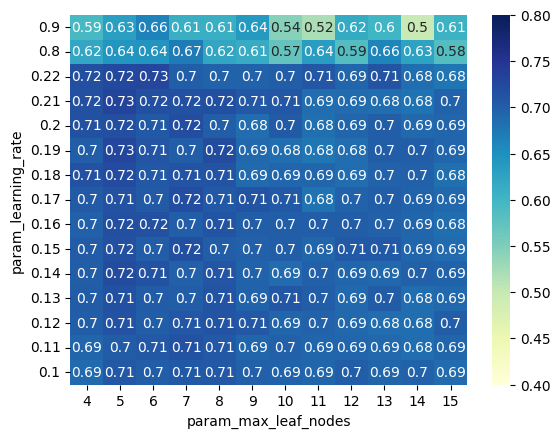

In [ ]:
import seaborn as sns

ax = sns.heatmap(pivoted_cv_results, annot=True, cmap="YlGnBu", vmin=0.4,
                 vmax=0.8)
ax.invert_yaxis()